In [1]:
import sys  
sys.path.insert(0, './..')

from constants import PATH_DATA,PATH_TRAIN,PATH_PICKLE,TRAIN,TEST
from import_images import extract_images,get_dicom_filepaths,get_dicom_infos
from plot_images import plot_samples
from import_study_level import get_study_level
from import_image_level import get_image_level
import matplotlib.pyplot as plt
import os
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import pydicom as dicom

import pandas as pd
from collections import defaultdict
import cv2

In [2]:
filepath = os.path.join("..",PATH_PICKLE,TRAIN,"dicom_infos.pkl")
pd_dicom = pd.read_pickle(filepath)

In [3]:
pd_dicom.describe()

,Series Number,Instance Number,Samples per Pixel,Rows,Columns,Bits Allocated,Bits Stored,High Bit,Pixel Representation
count,5835.000000,5833.000000,6086.0,6086.000000,6086.000000,6086.000000,6086.000000,6086.000000,6086.0
mean,62.753556,5.827876,1.0,2753.219849,3188.576405,15.495235,12.508380,11.508380,0.0
std,650.840789,69.136854,0.0,561.398080,683.963642,1.945239,1.754022,1.754022,0.0
min,1.000000,1.000000,1.0,846.000000,1140.000000,8.000000,8.000000,7.000000,0.0
25%,1.000000,1.000000,1.0,2336.000000,2836.000000,16.000000,12.000000,11.000000,0.0
50%,1.000000,1.000000,1.0,2544.000000,3029.000000,16.000000,12.000000,11.000000,0.0
75%,1.000000,1.000000,1.0,3198.000000,3408.000000,16.000000,14.000000,13.000000,0.0
max,10320.000000,1003.000000,1.0,4891.000000,4891.000000,16.000000,16.000000,15.000000,0.0


## About Rows

In [4]:
pd_dicom.Rows.value_counts().head(20)

3480    929
2336    658
3488    422
2544    334
2320    321
2800    258
2539    227
2801    190
2520    157
2436    156
2330    156
3052    138
3032    129
1760    129
1140    124
2991    110
2540     91
2874     86
2416     80
2536     73
Name: Rows, dtype: int64

In [5]:
pd_dicom.Rows.min()

846

## About Columns

In [6]:
pd_dicom.Columns.value_counts().head(20)

2836    640
4240    472
4248    460
3032    427
4256    409
3056    344
2832    298
3408    267
3050    225
2846    147
2992    147
2802    135
2140    129
2880    128
1387    124
3052    107
2872     81
3048     69
2840     67
4891     54
Name: Columns, dtype: int64

In [7]:
pd_dicom.Columns.min()

1140

### Need to find a common resolution, which one ?


In [8]:
pd_dicom['Bits Allocated'].value_counts().head(20)


16    5702
8      384
Name: Bits Allocated, dtype: int64

In [9]:
pd_dicom['Bits Stored'].value_counts().head(20)

12    4137
15    1191
8      384
14     206
16     162
13       3
10       3
Name: Bits Stored, dtype: int64

In [10]:
pd_dicom.columns

Index(['Specific Character Set', 'Image Type', 'SOP Class UID',
       'SOP Instance UID', 'Study Date', 'Study Time', 'Accession Number',
       'Modality', 'Patient's Name', 'Patient ID', 'Patient's Sex',
       'De-identification Method', 'Body Part Examined',
       'Imager Pixel Spacing', 'Study Instance UID', 'Series Instance UID',
       'Study ID', 'Series Number', 'Instance Number', 'Samples per Pixel',
       'Photometric Interpretation', 'Rows', 'Columns', 'Bits Allocated',
       'Bits Stored', 'High Bit', 'Pixel Representation', 'TransferSyntaxUID'],
      dtype='object')

In [11]:
for key in pd_dicom.columns:
    print(pd_dicom[key].value_counts())
    print("**********************************************************************************************")

ISO_IR 100    5891
ISO_IR 192     195
Name: Specific Character Set, dtype: int64
**********************************************************************************************
[ORIGINAL, PRIMARY]                                                               3545
[DERIVED, PRIMARY]                                                                1342
[ORIGINAL, PRIMARY, ]                                                              389
[DERIVED, SECONDARY, , CSA RESAMPLED]                                              363
[DERIVED, PRIMARY, ]                                                               190
[ORIGINAL, SECONDARY]                                                              187
ORIGINAL                                                                            20
[DERIVED, PRIMARY, POST_PROCESSED, RT, , , , , 100000]                              17
[ORIGINAL, SECONDARY, ORIGINAL, PRIMARY, ]                                          14
[ORIGINAL, PRIMARY, , RAD]               

### Field to check
* "Modality" ?
* "Patient's Sex"
* "Body Part Examined"
* "Imager Pixel Spacing" ?
* "Photometric Interpretation" ?
* Rows / Columns
* Bits Allocated / Bits Stored / High Bit

## Extract one picture

In [12]:
pd_dicom[['Study Instance UID','Series Instance UID']]
pd_dicom.iloc[0]

Specific Character Set                                               ISO_IR 100
Image Type                                                   [DERIVED, PRIMARY]
SOP Class UID                                                      71228e4340de
SOP Instance UID                                                   a6fae815f05c
Study Date                                                         5c32e85f2c8a
Study Time                                                         d84042708d92
Accession Number                                                   20a424073ba3
Modality                                                                     DX
Patient's Name                             (e, 4, 5, 7, 7, 3, f, b, 0, 9, 7, 3)
Patient ID                                                         2a2be6d95ded
Patient's Sex                                                                 M
De-identification Method      CTP Default:  based on DICOM PS3.15 AnnexE. De...
Body Part Examined                      

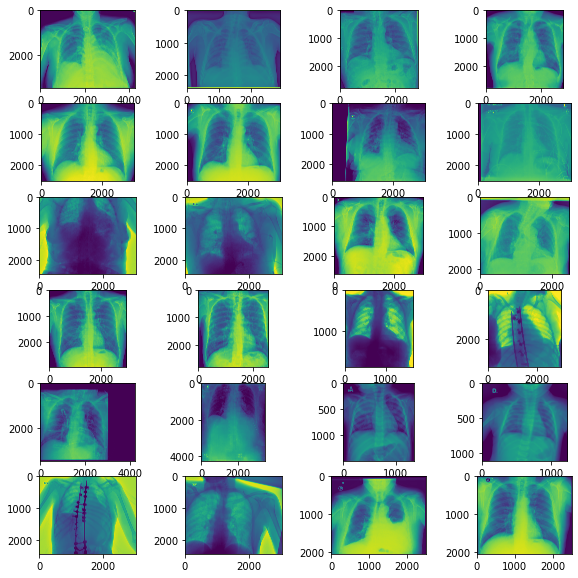

In [13]:
nb_sample_by_value = 2
column = 'Body Part Examined'

values = pd_dicom[column].value_counts()
np_images = list()
for i in values.index:
    pd_samples = pd_dicom[pd_dicom[column] == i].sample(nb_sample_by_value)
    np_images.extend(extract_images(TRAIN,pd_samples))
plot_samples(np_images)

## Study level

In [14]:
pd_study_level = get_study_level()
pd_study_level.loc['00c74279c5b7']


Negative for Pneumonia      1
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
Name: 00c74279c5b7, dtype: int64

## Study / Serie / Image

In [15]:
pd_dicom['Series Instance UID'].value_counts()

d5832b266b40    3
309ec8192930    2
3820314c6ed2    1
baa2dfbc8678    1
9a9f0d2d8c15    1
               ..
6716ce1dc925    1
9d3840967ecf    1
37bd5b1d9716    1
925ce437f62a    1
8e1a9b96b9df    1
Name: Series Instance UID, Length: 6083, dtype: int64

In [16]:
pd_dicom[pd_dicom['Series Instance UID']=='d5832b266b40'][['SOP Class UID',
       'SOP Instance UID', 'Study Date', 'Study Time', 'Accession Number',
       'Modality', "Patient's Name", 'Patient ID', "Patient's Sex",
       'De-identification Method', 'Body Part Examined',
       'Imager Pixel Spacing', 'Study Instance UID', 'Series Instance UID',
       'Study ID', 'Series Number', 'Instance Number']]

,SOP Class UID,SOP Instance UID,Study Date,Study Time,Accession Number,Modality,Patient's Name,Patient ID,Patient's Sex,De-identification Method,Body Part Examined,Imager Pixel Spacing,Study Instance UID,Series Instance UID,Study ID,Series Number,Instance Number
4612,71228e4340de,99f3642f50f5,02267ebf0f19,baf9d39f857d,99724f1bdf8b,DX,"(0, 3, 5, 9, 3, f, 8, c, 7, 2, 2, 8)",03593f8c7228,M,RSNA Covid-19 Dataset Default,CHEST,"[0.125, 0.125]",21b8491fb0e0,d5832b266b40,55625fb42f3f,1.0,1.0
4613,71228e4340de,b6b74c8a97e4,02267ebf0f19,baf9d39f857d,99724f1bdf8b,DX,"(0, 3, 5, 9, 3, f, 8, c, 7, 2, 2, 8)",03593f8c7228,M,RSNA Covid-19 Dataset Default,CHEST,"[0.125, 0.125]",21b8491fb0e0,d5832b266b40,55625fb42f3f,1.0,1.0
4614,71228e4340de,32222cc776a2,02267ebf0f19,baf9d39f857d,99724f1bdf8b,DX,"(0, 3, 5, 9, 3, f, 8, c, 7, 2, 2, 8)",03593f8c7228,M,RSNA Covid-19 Dataset Default,CHEST,"[0.125, 0.125]",21b8491fb0e0,d5832b266b40,55625fb42f3f,1.0,1.0


In [17]:
pd_dicom.columns

Index(['Specific Character Set', 'Image Type', 'SOP Class UID',
       'SOP Instance UID', 'Study Date', 'Study Time', 'Accession Number',
       'Modality', 'Patient's Name', 'Patient ID', 'Patient's Sex',
       'De-identification Method', 'Body Part Examined',
       'Imager Pixel Spacing', 'Study Instance UID', 'Series Instance UID',
       'Study ID', 'Series Number', 'Instance Number', 'Samples per Pixel',
       'Photometric Interpretation', 'Rows', 'Columns', 'Bits Allocated',
       'Bits Stored', 'High Bit', 'Pixel Representation', 'TransferSyntaxUID'],
      dtype='object')

In [18]:
pd_dicom['Study Instance UID'].value_counts()

0fd2db233deb    9
a7335b2f9815    7
8943d1d85097    6
a0254bf8a96e    5
a4e94133d95a    5
               ..
895c41c283cd    1
4a5bba561d65    1
345f8129863d    1
77f901809e36    1
0c5c7da459a3    1
Name: Study Instance UID, Length: 5819, dtype: int64

In [19]:
pd_dicom[pd_dicom['Study Instance UID']=='0fd2db233deb'][['SOP Class UID',
       'SOP Instance UID', 'Study Date', 'Study Time', 'Accession Number',
       'Modality', "Patient's Name", 'Patient ID', "Patient's Sex",
       'De-identification Method', 'Body Part Examined',
       'Imager Pixel Spacing', 'Study Instance UID', 'Series Instance UID',
       'Study ID', 'Series Number', 'Instance Number']]

,SOP Class UID,SOP Instance UID,Study Date,Study Time,Accession Number,Modality,Patient's Name,Patient ID,Patient's Sex,De-identification Method,Body Part Examined,Imager Pixel Spacing,Study Instance UID,Series Instance UID,Study ID,Series Number,Instance Number
5315,03a65300fa41,05c063f5cef5,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,06feab2c43b9,55625fb42f3f,5.0,1.0
5316,03a65300fa41,156cb1f5c689,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,a4fec64f5b97,55625fb42f3f,8.0,1.0
5317,03a65300fa41,c6e92e59a0ae,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,01050ddc661b,55625fb42f3f,10.0,1.0
5318,03a65300fa41,4c414b793562,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,6986b53f6431,55625fb42f3f,4.0,1.0
5319,03a65300fa41,04cc2f7f4c4b,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,f759743147f8,55625fb42f3f,9.0,1.0
5320,03a65300fa41,bee62c601ae9,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,ad6876d5e56a,55625fb42f3f,7.0,1.0
5321,03a65300fa41,a5a364383f34,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,b8c20a915593,55625fb42f3f,3.0,1.0
5322,03a65300fa41,b121806162c3,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,2019d0f0cd58,55625fb42f3f,2.0,1.0
5323,03a65300fa41,26f643772090,7e825928c7af,97af3f0f1be3,88eaab92365f,CR,"(1, d, 2, 4, 7, 1, c, b, 6, a, d, 1)",b3c0c7ed9a98,F,CTP Default: based on DICOM PS3.15 AnnexE. De...,CHEST,"[0.143, 0.143]",0fd2db233deb,9025f953c3d2,55625fb42f3f,1.0,1.0


In [20]:
pd_study_count = pd_dicom['Study Instance UID'].value_counts()
pd_study_count[pd_study_count.values> 1].count()

219

219 studies with 2 or more series  
2 series with 2 or more images

## number of boxes by label

In [21]:
pd_image_level = get_image_level()


In [22]:
pd_image_level['nb_boxes']=pd_image_level.boxes.str.len()

In [23]:
pd_image_level.nb_boxes.value_counts()

2    3113
0    2040
1     973
3     183
4      23
8       1
5       1
Name: nb_boxes, dtype: int64

In [24]:
pd_study_level.sum(axis=1).value_counts()

1    6054
dtype: int64

In [25]:
def update_label(x):
    if x['Negative for Pneumonia']:
        return 'NEGATIVE'
    elif x['Typical Appearance']:
        return 'TYPICAL'    
    elif x['Indeterminate Appearance']:
        return 'INDETERMINATE'    
    elif x['Atypical Appearance']:
        return 'ATYPICAL' 

pd_study_level['label']=pd_study_level.apply(update_label,axis=1)

In [26]:
pd_study_level.label.value_counts()

TYPICAL          2855
NEGATIVE         1676
INDETERMINATE    1049
ATYPICAL          474
Name: label, dtype: int64

In [27]:
pd_merge_level = pd.merge(
    pd_study_level,
    pd_image_level,
    how="inner",
    on=None,
    left_on='id',
    right_on='StudyInstanceUID',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_s", "_i"),
    copy=True,
    indicator=False,
    validate=None,
)

In [28]:
pd.pivot_table(pd_merge_level[['label_s','nb_boxes']], index=['label_s'],columns=['nb_boxes'], aggfunc=len,fill_value = 0)

nb_boxes,0,1,2,3,4,5,8
label_s,,,,,,,
ATYPICAL,92,261,115,14,1,0,0
INDETERMINATE,59,685,345,17,1,1,0
NEGATIVE,1736,0,0,0,0,0,0
TYPICAL,153,27,2653,152,21,0,1


### Question : remove images with atypical / indeterminate / typical and nb_boxes = 0 ??

## Save 16bit images

In [29]:
res = extract_images(TRAIN,pd_dicom.loc[0:1])
pd_dicom.loc[0:1]
im_15b = res[1][3]
Photometric = res[1][4]

In [30]:
if Photometric == "MONOCHROME1":
        im_15b = np.amax(im_15b) - im_15b
cv2.imwrite('im_15b.png',im_15b )

True

In [31]:
im_15b_n = cv2.imread('im_15b.png',cv2.IMREAD_UNCHANGED)

In [32]:
row = pd_dicom.loc[1]
filepath = os.path.join(PATH_DATA,TRAIN,row['Study Instance UID'],row['Series Instance UID'],f"{row['SOP Instance UID']}.dcm")
ds = dicom.read_file(filepath)

In [33]:
data = apply_voi_lut(ds.pixel_array, ds)

In [34]:
im_15b_400 = cv2.resize(im_15b,(400,400))

In [35]:
im_15b_400.shape


(400, 400)

In [36]:
#cv2.imshow("resize2",im_15b_400_norm)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [37]:
im_15b_400_norm = (im_15b_400 - im_15b_400.min()) / (im_15b_400.max() - im_15b_400.min())

In [38]:
im_15b_400_norm

array([[0.00000000e+00, 6.27976346e-04, 4.95054686e-02, ...,
        1.50661992e-01, 1.60081637e-01, 1.91323460e-01],
       [0.00000000e+00, 3.40677168e-02, 2.08802135e-02, ...,
        1.28630488e-01, 1.37317494e-01, 1.60971270e-01],
       [1.43911246e-02, 3.03521901e-03, 0.00000000e+00, ...,
        1.20728453e-01, 1.32503009e-01, 1.61703909e-01],
       ...,
       [7.82615521e-01, 7.98367261e-01, 7.85389084e-01, ...,
        7.07049034e-01, 7.18718928e-01, 7.02600869e-01],
       [7.76492752e-01, 7.96221676e-01, 7.97006646e-01, ...,
        7.28190905e-01, 7.17619970e-01, 7.16782668e-01],
       [7.89627924e-01, 7.86906693e-01, 7.93709770e-01, ...,
        7.14427757e-01, 7.25783662e-01, 7.07206029e-01]])

In [49]:
pd_image_level.loc['64a776818efe'].StudyInstanceUID
pd_study_level.loc['0a1a3dd9e738'].label


'ATYPICAL'